Author: Hem N Chaudhary

Date: Jan, 2024

Description: Making Transformers Efficient in Production. Covered knowledge distillation, quantization, conversion to Onnx

In [ ]:
# !pip uninstall accelerate
# !pip uninstall transformers
!pip install git+https://github.com/huggingface/accelerate
!pip install --upgrade transformers

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-dwzcvw7o
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-dwzcvw7o
  Resolved https://github.com/huggingface/accelerate to commit 162a82164e9bdcc01a173cbee43b686437aaead8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#Intent Detection as a Case Study
#using BERT finetuned on CLINC150 for baseline

from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
#passing a query to get the predicted intent and confidence score from the model

query = "Hey I'd like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van"

pipe(query)

[{'label': 'car_rental', 'score': 0.5530847311019897}]

In [ ]:
#benchmark measuring Model performance, Latency, and Memory for a given pipeline and test set

class PerformanceBenchmark:
  def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
    self.pipeline = pipeline
    self.dataset = dataset
    self.optim_type = optim_type

  def compute_accuracy(self):
    #
    pass

  def compute_size(self):
    #
    pass

  def time_pipeline(self):
    #
    pass

  def run_benchmark(self):
    metrics = {}
    metrics[self.optim_type] = self.compute_size()
    metrics[self.optim_type].update(self.compute_accuracy())
    metrics[self.optim_type].update(self.time_pipeline())
    return metrics

In [ ]:
!pip install datasets

In [ ]:
#Computing model accuracy on the test set, CLINC150
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

In [ ]:
#peeking at clinc

sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [ ]:
#Intent ID to strings

intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])
#print(intents.names[133])

'transfer'

In [ ]:
#loading accuracy metric

from datasets import load_metric

accuracy_score = load_metric("accuracy")

<ipython-input-9-38ae67564cc0>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
def compute_accuracy(self):
    #Accuracy metric in previous cell expects preds and ref to be int
    #Collecting all the preds and labels in lists before returning accuracy on dataset
    """ This overrides the PerformanceBenchmark.compute() method"""
    preds, labels = [],[]
    for example in self.dataset:
      pred = self.pipeline(example["text"])[0]["label"]
      label = example["intent"]
      preds.append(intents.str2int(pred))
      labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [ ]:
#computing the size of our model using torch.save()

#looking at what is stored in the state_dict of our baseline model

print(len(list(pipe.model.state_dict().items())))

list(pipe.model.state_dict().items())[42]

201


('bert.encoder.layer.2.attention.self.value.bias',
 tensor([-2.7834e-02,  4.9434e-02,  8.3551e-02,  4.1092e-02,  6.0157e-01,
          1.1774e-01, -5.2112e-02, -6.5143e-02, -2.9358e-02, -4.2250e-02,
          7.9177e-02,  8.0409e-02,  2.9921e-03,  1.7816e-01, -5.0480e-02,
         -1.5634e-01, -2.1707e-02,  1.4381e-02,  2.5132e-02, -2.4110e-02,
         -1.9183e-01, -7.8657e-02,  5.0709e-02,  3.3632e-02, -3.1946e-02,
          1.1616e-01,  9.2720e-02, -1.1787e-01,  2.3233e-01, -1.2678e-02,
         -1.3138e-01, -4.0024e-02,  7.4823e-02, -5.4148e-02, -1.5184e-01,
         -7.4407e-02,  1.1559e-01,  8.2729e-02, -1.3787e-01,  8.3528e-02,
          1.2154e-01,  1.6880e-02, -5.6629e-02, -3.9295e-02,  5.3725e-02,
          6.8602e-02, -1.1294e-01,  4.4001e-02, -2.5884e-01,  1.6767e-01,
          1.8316e-01,  5.6272e-02, -3.6874e-02, -2.7938e-02, -9.3204e-02,
         -7.5239e-03,  4.1141e-02, -1.1542e-02, -9.9749e-02, -3.0910e-02,
          4.1398e-02, -4.4389e-02, -2.6279e-02,  7.2100e-02, 

In [ ]:
!pip install torch

In [ ]:
#saving the model with:
import torch as torch
torch.save(pipe.model.state_dict(), "model.pt")

In [ ]:
#then using path.stat() to get info about the underlying files. Putting together

from pathlib import Path

def compute_size(self):
  """This overrides the PerformanceBenchmark.compute_size() method"""
  state_dict = self.pipeline.model.state_dict()
  tmp_path = Path("model.pt")
  torch.save(state_dict, tmp_path)
  #Calculate size in megabytes
  size_mb = Path(tmp_path).stat().st_size/(1024*1024)
  #Delete temporary file
  tmp_path.unlink()
  print(f"Model size (MB) - {size_mb:.2f}")
  return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [ ]:
#using perf_counter() to calculate inference time of models

from time import perf_counter

for _ in range(3):
  start_time = perf_counter()
  _ = pipe(query)
  latency = perf_counter() - start_time
  print(f"Latancy(ms) - {1000*latency:.3f}")

Latancy(ms) - 88.061
Latancy(ms) - 95.253
Latancy(ms) - 96.843


In [ ]:
#collecting latencies over many runs and then use the distribution for mean and std

import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
  """This overrides the PerformanceBenchmark.time_pipeline() method"""
  latencies = []
  #warmup
  for _ in range(10):
    _ = self.pipeline(query)
  #Timed run
  for _ in range(100):
    start_time = perf_counter()
    _ = self.pipeline(query)
    latency = perf_counter() - start_time
    latencies.append(latency)
  #compute run statistics
  time_avg_ms = 1000*np.mean(latencies)
  time_std_ms = 1000*np.std(latencies)
  print(f"Average latency(ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
  return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [ ]:
#testing PerformanceBenchmark on BERT baseline

pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.15
Accuracy on test set - 0.867
Average latency(ms) - 39.16 +\- 2.68


**Knowledge Distillation**

In [ ]:
#using fine-tuned BERT-base model as teacher to fine-tune smaller, faster model

#augmenting cross-entrpy loss with an L_KD term in custom trainer

#adding new hyperparameters by subclassing TrainingArguments

from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
  def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
    super().__init__(*args, **kwargs)
    self.alpha = alpha
    self.temperature = temperature


In [ ]:
#adding new loss function by subclassing Trainer and overriding the compute_loss()

import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
  def __init__(self, *args, teacher_model=None, **kwargs):
    super().__init__(*args, **kwargs)
    self.teacher_model = teacher_model

  def compute_loss(self, model, inputs, return_outputs=False):
    outputs_stu = model(**inputs)
    #Extract cross-entrpy loss and logits from student
    loss_ce = outputs_stu.loss
    logits_stu = outputs_stu.logits
    #Extract logits from teacher
    with torch.no_grad():
      outputs_tea = self.teacher_model(**inputs)
      logits_tea = outputs_tea.logits
    #Soften probabilities and compute distillation loss
    loss_fct = nn.KLDivLoss(reduction="batchmean")
    loss_kd = self.args.temperature**2 * loss_fct(
        F.log_softmax(logits_stu / self.args.temperature, dim=-1),
        F.softmax(logits_tea / self.args.temperature, dim=-1))
    #Return weighted student loss
    loss = self.args.alpha * loss_ce + (1. -self.args.alpha) * loss_kd
    return (loss, outputs_stu) if return_outputs else loss


In [ ]:
print(clinc)

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})


**Choosing a Good Student Initialization**

In [ ]:
#using DistilBERT as student with its 40% fewer parameters

#tokenizing and encoding queries

from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
  return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
#clinc_enc_txt = clinc.map(tokenize_text, batched=True)
clinc_enc = clinc_enc.rename_column("intent", "labels")



In [ ]:
#login detail
from google.colab import userdata
key=userdata.get('huggingface')

from huggingface_hub import login
login(token=key, write_permission=True )

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
#defining metrics to trak during training; using accuracy as the main metric

def compute_metrics(preds):
  predictions, labels = preds
  predictions = np.argmax(predictions, axis=1)
  return accuracy_score.compute(predictions=predictions, references=labels)

In [ ]:
#defining training arguments; To warmup, set alpha=1 to see how well DistilBERT performs without any signla from teacher
#pushing the fine-tuned model to a new repo distilbert-base-uncased-finetuned-clinic

batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinic"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy="epoch",
    num_train_epochs=5, learning_rate=2e-5, per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01, push_to_hub=True)

In [ ]:
#creating student_init() function to initialize the models with each new run

#But before need to provide student model with the mapings between intent and label

id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id



In [ ]:
#creating custom model configuration for student

from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig.from_pretrained(student_ckpt, num_labels=num_labels,
                                            id2label=id2label, label2id=label2id))

In [ ]:
#providing the configuration to the from_pretrained() fn of AutoModelFOrSequenceClassification

import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
  return (AutoModelForSequenceClassification.from_pretrained(student_ckpt, config=student_config).to(device))

In [ ]:
#all the ingredients in place, downloading teacher and fine-tune

teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_ckpt, num_labels=num_labels).to(device)

distilbert_trainer = DistillationTrainer(model_init=student_init, teacher_model=teacher_model,
                                         args=student_training_args,
                                         train_dataset=clinc_enc['train'],
                                         eval_dataset=clinc_enc['validation'],
                                         compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.303337,0.746452
2,3.807300,1.899217,0.864839
3,3.807300,1.178517,0.894194
4,1.720000,0.875852,0.909355
5,0.920800,0.792727,0.915161


TrainOutput(global_step=1590, training_loss=2.072857392509029, metrics={'train_runtime': 305.2199, 'train_samples_per_second': 249.82, 'train_steps_per_second': 5.209, 'total_flos': 413455351535688.0, 'train_loss': 2.072857392509029, 'epoch': 5.0})

In [ ]:
#Pushing to the hub
distilbert_trainer.push_to_hub("Training completed!")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1706026378.99e8694adbdf.39534.1:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/hndc/distilbert-base-uncased-finetuned-clinic/commit/2be23bb49c8f67ae6ff5ea54d7a0912cc6b6f425', commit_message='Training completed!', commit_description='', oid='2be23bb49c8f67ae6ff5ea54d7a0912cc6b6f425', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
#benchmarking the tuned model

finetuned_ckpt = "hndc/distilbert-base-uncased-finetuned-clinic"
pipe = pipeline("text-classification", model=finetuned_ckpt)



In [ ]:
#passing the pipeline to our PerformanceBenchmark

optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Accuracy on test set - 0.838
Average latency(ms) - 19.63 +\- 1.18


In [ ]:
print(type(perf_metrics))

<class 'dict'>


In [ ]:
import matplotlib.pyplot as plt

<ipython-input-32-c1e7db668336>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


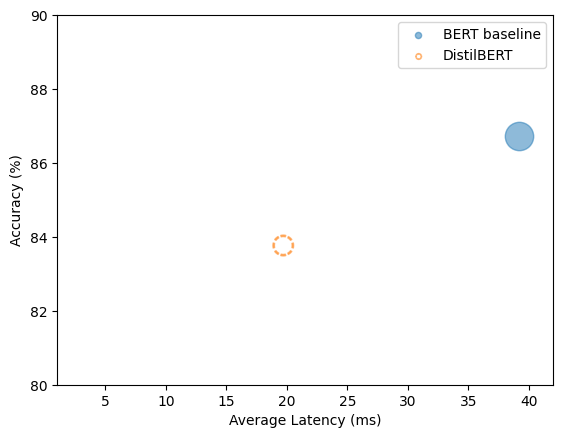

In [ ]:
#creating a scatter plot to compare results against baseline ; accuracy against the latency, w radius of each point corresponding to the size of the model on the disl

import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
  df = pd.DataFrame.from_dict(perf_metrics, orient="index")

  for idx in df.index:
    df_opt = df.loc[idx]
    #Add a dashed circle around the current optimization type
    if idx == current_optim_type:
      plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, alpha=0.5, s=df_opt["size_mb"],
                  label=idx, marker='$\u25CC$')
    else:
      plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, s=df_opt["size_mb"], label=idx, alpha=0.5)

  legend = plt.legend(bbox_to_anchor=(1,1))
  for handle in legend.legendHandles:
    handle.set_sizes([20])

  plt.ylim(80,90)
  #Use the slowest model to define the x-axis range
  xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
  plt.xlim(1, xlim)
  plt.ylabel("Accuracy (%)")
  plt.xlabel("Average Latency (ms)")
  plt.show()


plot_metrics(perf_metrics, optim_type)

**Finding Good Hyperparameters with Optuna**

In [ ]:
#Using Optuna to find better alpha and T

# defining a toy objective function

def objective(trial):
  x = trial.suggest_float("x", -2, 2)
  y = trial.suggest_float("y", -2, 2)
  return (1-x)**2 + 100*(y-x**2)**2

In [ ]:
! pip install optuna

In [ ]:
#Optuna collects multipe trails as a study, pass objective to study.optimize()

import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2024-01-24 01:56:52,688] A new study created in memory with name: no-name-237c2e79-446c-429a-bed2-be2143d4d2ad
[I 2024-01-24 01:56:52,691] Trial 0 finished with value: 570.2071199881491 and parameters: {'x': -1.8543323640370102, 'y': 1.0677682507827457}. Best is trial 0 with value: 570.2071199881491.
[I 2024-01-24 01:56:52,693] Trial 1 finished with value: 57.38734033535626 and parameters: {'x': 1.2714949964611635, 'y': 0.859641861100223}. Best is trial 1 with value: 57.38734033535626.
[I 2024-01-24 01:56:52,696] Trial 2 finished with value: 26.279145400386863 and parameters: {'x': 1.2749110444013785, 'y': 1.1135039504420154}. Best is trial 2 with value: 26.279145400386863.
[I 2024-01-24 01:56:52,698] Trial 3 finished with value: 176.93273989282363 and parameters: {'x': 0.8722329692501942, 'y': -0.5693089499566599}. Best is trial 2 with value: 26.279145400386863.
[I 2024-01-24 01:56:52,700] Trial 4 finished with value: 1308.666318460425 and parameters: {'x': -1.3303075683159307, 'y'

In [ ]:
#find the best parameters

study.best_params

{'x': 0.9940166705778987, 'y': 0.9892164577124567}

In [ ]:
#defining hyperparameters space over to optimize

def hp_space(trail):
  return {
      "num_train_epochs": trail.suggest_int("num_train_epochs", 5, 10),
      "alpha": trail.suggest_float("alpha", 0, 1),
      "temperature": trail.suggest_int("temperature", 2, 20)
  }

In [ ]:
#running the hyperparameter search with Trainer

best_run = distilbert_trainer.hyperparameter_search(n_trials=20, direction="maximize", hp_space=hp_space)


[I 2024-01-23 16:47:36,739] A new study created in memory with name: no-name-28e1a6c5-989c-41fb-ac41-1caa68b56c5d
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.202355,0.612258
2,0.323700,0.100802,0.818710
3,0.323700,0.067339,0.876452
4,0.115600,0.052981,0.897742
5,0.076100,0.045068,0.902903
6,0.076100,0.041217,0.906774
7,0.062700,0.040039,0.906452


[I 2024-01-23 16:54:47,394] Trial 0 finished with value: 0.9064516129032258 and parameters: {'num_train_epochs': 7, 'alpha': 0.7143131281575181, 'temperature': 11}. Best is trial 0 with value: 0.9064516129032258.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.229898,0.618065
2,0.360500,0.115963,0.811613
3,0.360500,0.079959,0.867097
4,0.133500,0.066186,0.885161
5,0.093600,0.061893,0.886129


[I 2024-01-23 17:00:07,575] Trial 1 finished with value: 0.8861290322580645 and parameters: {'num_train_epochs': 5, 'alpha': 0.3439719251489417, 'temperature': 6}. Best is trial 0 with value: 0.9064516129032258.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.241141,0.631613
2,0.377700,0.119460,0.817742
3,0.377700,0.081182,0.867097
4,0.137800,0.066687,0.885484
5,0.095400,0.062229,0.886774


[I 2024-01-23 17:05:36,063] Trial 2 finished with value: 0.886774193548387 and parameters: {'num_train_epochs': 5, 'alpha': 0.759039271861527, 'temperature': 5}. Best is trial 0 with value: 0.9064516129032258.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.199814,0.626774
2,0.324000,0.096455,0.828710
3,0.324000,0.061595,0.884194
4,0.110700,0.046647,0.903548
5,0.069200,0.038250,0.909677
6,0.069200,0.033316,0.919355
7,0.053900,0.030774,0.923548
8,0.046400,0.028615,0.926774
9,0.046400,0.027388,0.927742
10,0.042900,0.027072,0.928387


[I 2024-01-23 17:16:12,439] Trial 3 finished with value: 0.9283870967741935 and parameters: {'num_train_epochs': 10, 'alpha': 0.924670627776918, 'temperature': 10}. Best is trial 3 with value: 0.9283870967741935.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.196068,0.596774
2,0.312000,0.100759,0.808710
3,0.312000,0.069819,0.868387
4,0.115200,0.056676,0.892581
5,0.079100,0.049996,0.894839
6,0.079100,0.048079,0.897742


[I 2024-01-23 17:22:24,759] Trial 4 finished with value: 0.8977419354838709 and parameters: {'num_train_epochs': 6, 'alpha': 0.7650015549981369, 'temperature': 19}. Best is trial 3 with value: 0.9283870967741935.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.207164,0.621290
2,0.331400,0.102346,0.820000
3,0.331400,0.067820,0.877419
4,0.117500,0.053100,0.897097
5,0.076900,0.045061,0.902903
6,0.076900,0.041146,0.907419
7,0.063200,0.039950,0.907742


[I 2024-01-23 17:29:36,491] Trial 5 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.199814,0.626774
2,0.324000,0.096455,0.828710
3,0.324000,0.061595,0.884194
4,0.110700,0.046647,0.903548
5,0.069200,0.038250,0.909677
6,0.069200,0.033316,0.919355
7,0.053900,0.030774,0.923548
8,0.046400,0.028615,0.926774
9,0.046400,0.027388,0.927742
10,0.042900,0.027072,0.928387


[I 2024-01-23 17:40:23,010] Trial 6 finished with value: 0.9283870967741935 and parameters: {'num_train_epochs': 10, 'alpha': 0.8067006596645674, 'temperature': 10}. Best is trial 3 with value: 0.9283870967741935.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.192811,0.613226


[I 2024-01-23 17:41:22,987] Trial 7 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.195949,0.603548


[I 2024-01-23 17:42:22,182] Trial 8 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.200256,0.587097


[I 2024-01-23 17:43:21,593] Trial 9 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.407687,0.695484
2,0.642800,0.139202,0.841613
3,0.642800,0.070367,0.898710
4,0.163000,0.050596,0.919677
5,0.081300,0.042428,0.926774
6,0.081300,0.037371,0.928065
7,0.061500,0.035419,0.931613
8,0.053600,0.033705,0.932581
9,0.053600,0.033094,0.933226


[I 2024-01-23 17:52:34,162] Trial 10 finished with value: 0.9332258064516129 and parameters: {'num_train_epochs': 9, 'alpha': 0.9464628409873767, 'temperature': 2}. Best is trial 10 with value: 0.9332258064516129.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.407687,0.695484


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.407687,0.695484
2,0.642800,0.139202,0.841613
3,0.642800,0.070367,0.898710
4,0.163000,0.050596,0.919677
5,0.081300,0.042428,0.926774
6,0.081300,0.037371,0.928065
7,0.061500,0.035419,0.931613
8,0.053600,0.033705,0.932581
9,0.053600,0.033094,0.933226


[I 2024-01-23 18:02:07,626] Trial 11 finished with value: 0.9332258064516129 and parameters: {'num_train_epochs': 9, 'alpha': 0.9937737785515707, 'temperature': 2}. Best is trial 10 with value: 0.9332258064516129.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.407687,0.695484
2,0.642800,0.139202,0.841613
3,0.642800,0.070367,0.898710
4,0.163000,0.050596,0.919677
5,0.081300,0.042428,0.926774
6,0.081300,0.037371,0.928065
7,0.061500,0.035419,0.931613
8,0.053600,0.033705,0.932581
9,0.053600,0.033094,0.933226


[I 2024-01-23 18:11:19,443] Trial 12 finished with value: 0.9332258064516129 and parameters: {'num_train_epochs': 9, 'alpha': 0.9688927570011859, 'temperature': 2}. Best is trial 10 with value: 0.9332258064516129.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.407687,0.695484
2,0.642800,0.139202,0.841613
3,0.642800,0.070367,0.898710
4,0.163000,0.050596,0.919677
5,0.081300,0.042428,0.926774
6,0.081300,0.037371,0.928065
7,0.061500,0.035419,0.931613
8,0.053600,0.033705,0.932581
9,0.053600,0.033094,0.933226


[I 2024-01-23 18:21:23,595] Trial 13 finished with value: 0.9332258064516129 and parameters: {'num_train_epochs': 9, 'alpha': 0.5462833281701369, 'temperature': 2}. Best is trial 10 with value: 0.9332258064516129.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.231633,0.643871
2,0.371300,0.107421,0.834194
3,0.371300,0.066895,0.883871


[I 2024-01-23 18:24:25,894] Trial 14 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.213600,0.628387


[I 2024-01-23 18:25:25,793] Trial 15 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.287391,0.674194
2,0.460100,0.116875,0.846452
3,0.460100,0.065586,0.892581
4,0.136600,0.047417,0.909355
5,0.076500,0.038786,0.921613
6,0.076500,0.033981,0.927097
7,0.058500,0.031913,0.929677


[I 2024-01-23 18:32:34,777] Trial 16 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.194729,0.619032


[I 2024-01-23 18:33:34,428] Trial 17 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.208915,0.626452


[I 2024-01-23 18:34:33,891] Trial 18 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.247991,0.654194
2,0.398900,0.109334,0.841935
3,0.398900,0.065109,0.888710
4,0.127100,0.047838,0.905484
5,0.075000,0.038961,0.916774
6,0.075000,0.034014,0.923548


[I 2024-01-23 18:40:44,037] Trial 19 pruned. 


In [ ]:
print(best_run)

BestRun(run_id='10', objective=0.9332258064516129, hyperparameters={'num_train_epochs': 9, 'alpha': 0.9464628409873767, 'temperature': 2}, run_summary=None)


In [ ]:
#updating our training arguments with these values and run the final training run

for k,v in best_run.hyperparameters.items():
  setattr(student_training_args, k, v)

#Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

#Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
                                     teacher_model=teacher_model, args=student_training_args,
                                     train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
                                     compute_metrics=compute_metrics, tokenizer=student_tokenizer)
distil_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.071423,0.759677
2,3.579300,1.564803,0.878710
3,3.579300,0.813925,0.909677
4,1.350700,0.506569,0.929355
5,0.483900,0.382818,0.939677
6,0.483900,0.336799,0.940000
7,0.243700,0.319506,0.942258
8,0.167300,0.312880,0.942581
9,0.167300,0.311150,0.943548


TrainOutput(global_step=2862, training_loss=1.0361964014507856, metrics={'train_runtime': 557.7821, 'train_samples_per_second': 246.064, 'train_steps_per_second': 5.131, 'total_flos': 743236042911180.0, 'train_loss': 1.0361964014507856, 'epoch': 9.0})

In [ ]:
distil_trainer.push_to_hub("Training complete")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/hndc/distilbert-base-uncased-distilled-clinc/commit/117ca00e9ccecae72b558eecc616f2b81c991c38', commit_message='Training complete', commit_description='', oid='117ca00e9ccecae72b558eecc616f2b81c991c38', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
#Benchmarking the Distilled Model

distilled_ckpt = "hndc/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Accuracy on test set - 0.887
Average latency(ms) - 27.71 +\- 4.64


<ipython-input-32-c1e7db668336>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


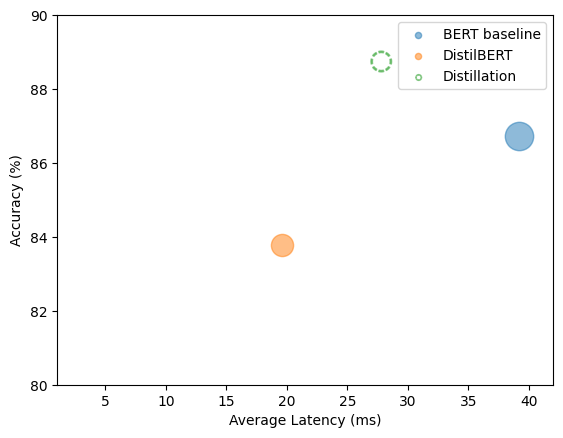

In [ ]:
#visualizing the results

plot_metrics(perf_metrics, optim_type)

**Quantization**

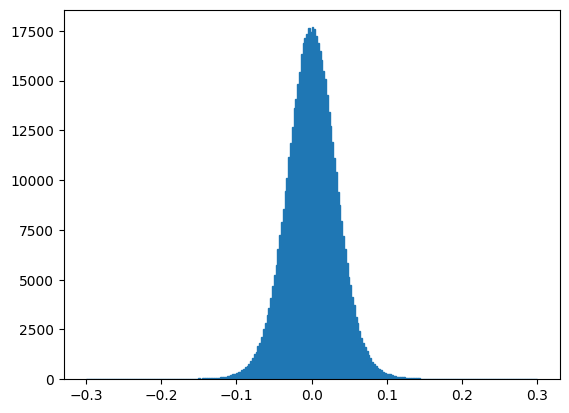

In [ ]:
#visualizing attention weight matrics from distiled model

import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3, 0.3), edgecolor="C0")
plt.show()

In [ ]:
# scaling to 8-bits; [q_max, q_min]=[-128, 127]

zero_point = 0
scale = (weights.max() - weights.min())/(127 - (-128))

In [ ]:
#quantizing the weights

(weights/scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   2,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   6,  ...,   0,   6,  -3],
        ...,
        [  6,   1,  13,  ...,  -1,   6,  -1],
        [  1,  -2, -12,  ...,  11,  -7, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -1]], dtype=torch.int8)

In [ ]:
#simplyfing the qunatization by using quantize_per_tensor() fn

from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   2,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   6,  ...,   0,   6,  -3],
        ...,
        [  6,   1,  13,  ...,  -1,   6,  -1],
        [  1,  -2, -12,  ...,  11,  -7, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -1]], dtype=torch.int8)

In [ ]:
# comparing the time it takes to compute the multiplication of two weight tensors with FP32 and INT8 values
%%timeit
weights @ weights

2.98 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# quantized tensors need QFunctional wrapper

from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [ ]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

240 µs ± 6.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
#verifying quantization reduce storage size by 4

import sys

sys.getsizeof(weights.storage())/sys.getsizeof(quantized_weights.storage())

3.999755879241598

In [ ]:
#quantization in PyTorch

from torch.quantization import quantize_dynamic

model_ckpt = "hndc/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

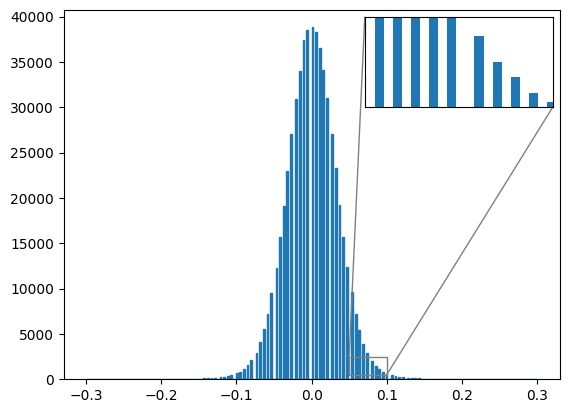

In [ ]:

#hide_input
#id weight-quantization
#alt Effect of quantization on a transformer's weights
#caption Effect of quantization on a transformer's weights
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# Create histogram
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().numpy(),
         bins=250, range=(-0.3,0.3), edgecolor="C0");
# Create zoom inset
axins = zoomed_inset_axes(ax, 5, loc='upper right')
axins.hist(quantized_weights.dequantize().flatten().numpy(),
         bins=250, range=(-0.3,0.3));
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

In [ ]:
#Benchmarking the Quantized Model

pipe = pipeline("text-classification", model=model_quantized, tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.39
Accuracy on test set - 0.895
Average latency(ms) - 11.51 +\- 0.61


<ipython-input-32-c1e7db668336>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


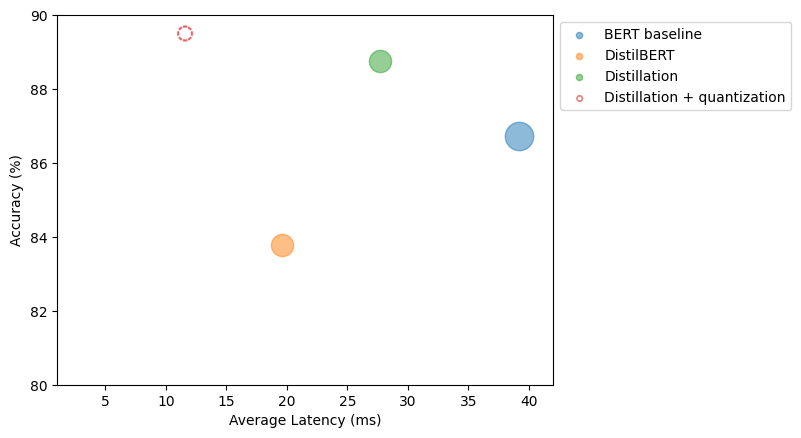

In [ ]:
#plotting the results

plot_metrics(perf_metrics, optim_type)

**Optimizing Inference with ONNX and ONNX Runtime**

In [ ]:
! pip install --upgrade onnx

In [ ]:
! pip install transformers

In [ ]:
from pathlib import Path

from transformers import AutoTokenizer


In [ ]:
#using convert_graph_to_onnx.convert() to see ORT in action
#Setting OpenMP environment

import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [ ]:
#emptying onnx folder
!rm -rf onnx/*

In [ ]:
#converting distilled model to the ONNX format

from transformers.convert_graph_to_onnx import convert

model_ckpt = "hndc/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

/usr/local/lib/python3.10/dist-packages/transformers/convert_graph_to_onnx.py:361: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  warnings.warn(


ONNX opset version set to: 12
Loading pipeline (model: hndc/distilbert-base-uncased-distilled-clinc, tokenizer: DistilBertTokenizerFast(name_or_path='hndc/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False,

/usr/local/lib/python3.10/dist-packages/transformers/models/distilbert/modeling_distilbert.py:246: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


In [ ]:
#! pip install onnxruntime

In [ ]:
#creating InferenceSession instance to feed inputs to the models

from onnxruntime import (GraphOptimizationLevel, InferenceSession,
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [ ]:
onnx_model = create_model_for_provider(onnx_model_path)

In [ ]:
#testing out the onnx_model with an example

inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [ ]:
#getting the predicted label

np.argmax(logits_onnx)

61

In [ ]:
#ground truth label

clinc_enc["test"][0]["labels"]

61

In [ ]:
#creating custom pipeline for ONNX model

from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [ ]:
# testing on the simple query about car_rental intent

pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.9454193}]

In [ ]:
#creating performance benchmark for ONNX models

class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [ ]:
#Benchmarking of +ORT

optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.98
Accuracy on test set - 0.887
Average latency(ms) - 22.23 +\- 0.65


<ipython-input-32-c1e7db668336>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


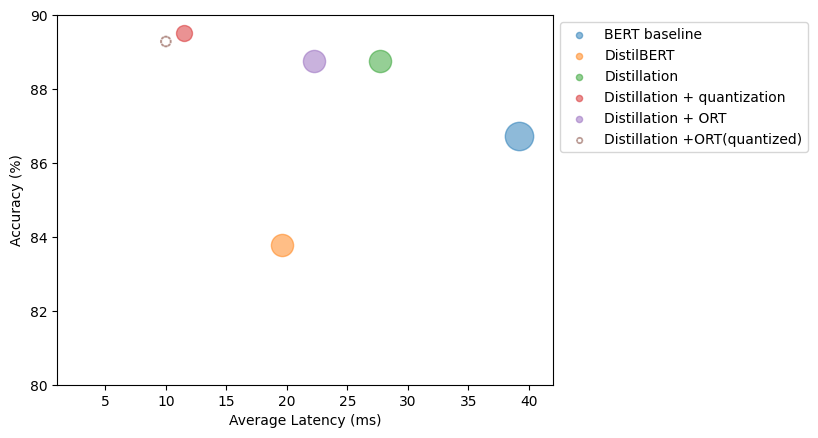

In [ ]:
plot_metrics(perf_metrics, optim_type)

In [ ]:
#adding quantization to the mix

from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model_quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.5/attention/MatMul]
Ignore MatM

In [ ]:
#running quantized model

onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation +ORT(quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 64.36
Accuracy on test set - 0.893
Average latency(ms) - 9.95 +\- 0.42


<ipython-input-32-c1e7db668336>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


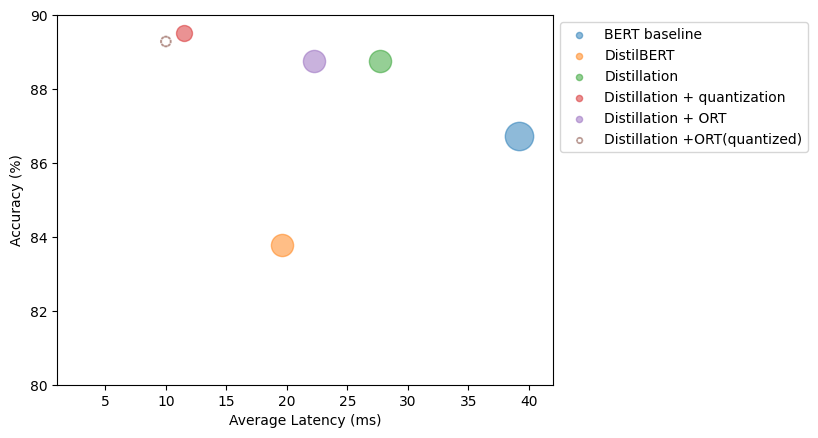

In [ ]:
plot_metrics(perf_metrics, optim_type)